# exp003_m_stage1
lightgbm

In [32]:
import os
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='darkgrid')

from tqdm import tqdm
from itertools import product

from sklearn.linear_model import LogisticRegression
import lightgbm as lgb
from optuna.integration import lightgbm as lgb_tuner
from catboost import CatBoost, FeaturesData, Pool

from sklearn.metrics import mean_squared_error, log_loss
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import RepeatedStratifiedKFold

In [33]:
# 設定
EXP_NAME = 'exp021_m_stage1'
INPUT_DIR = '../input/ncaam-march-mania-2021'
OUTPUT_DIR = f'../output/{EXP_NAME}'
SEED = 42

In [34]:
# 出力フォルダ生成
os.makedirs(OUTPUT_DIR)

FileExistsError: [Errno 17] File exists: '../output/exp021_m_stage1'

## データ読み込み

In [35]:
tourny_results = pd.read_csv(INPUT_DIR + '/MNCAATourneyDetailedResults.csv')
regular_results = pd.read_csv(INPUT_DIR + '/MRegularSeasonDetailedResults.csv')
seeds = pd.read_csv(INPUT_DIR + '/MNCAATourneySeeds.csv')
conf = pd.read_csv(INPUT_DIR + '/MTeamConferences.csv')
massey = pd.read_csv(INPUT_DIR + '/MMasseyOrdinals.csv')
kenpom = pd.read_csv(INPUT_DIR + '/NCAA2021_Kenpom.csv')

In [36]:
test = pd.read_csv(INPUT_DIR + '/MSampleSubmissionStage1.csv')

## 特徴量生成

In [37]:
def prepare_data(df):
    dfswap = df[['Season', 'DayNum', 'LTeamID', 'LScore', 'WTeamID', 'WScore', 'WLoc', 'NumOT', 
    'LFGM', 'LFGA', 'LFGM3', 'LFGA3', 'LFTM', 'LFTA', 'LOR', 'LDR', 'LAst', 'LTO', 'LStl', 'LBlk', 'LPF', 
    'WFGM', 'WFGA', 'WFGM3', 'WFGA3', 'WFTM', 'WFTA', 'WOR', 'WDR', 'WAst', 'WTO', 'WStl', 'WBlk', 'WPF']]

    dfswap.loc[df['WLoc'] == 'H', 'WLoc'] = 'A'
    dfswap.loc[df['WLoc'] == 'A', 'WLoc'] = 'H'
    df.columns.values[6] = 'location'
    dfswap.columns.values[6] = 'location'    
      
    df.columns = [x.replace('W','T1_').replace('L','T2_') for x in list(df.columns)]
    dfswap.columns = [x.replace('L','T1_').replace('W','T2_') for x in list(dfswap.columns)]

    output = pd.concat([df, dfswap]).reset_index(drop=True)
    output.loc[output.location=='N','location'] = '0'
    output.loc[output.location=='H','location'] = '1'
    output.loc[output.location=='A','location'] = '-1'
    output.location = output.location.astype(int)
    
    output['PointDiff'] = output['T1_Score'] - output['T2_Score']
    
    output['win'] = 1
    output.loc[output['T1_Score'] < output['T2_Score'],'win'] = 0
    
    #stats
    output['T1_Posses'] = 0.96*(output['T1_FGA']+output['T1_TO']+(0.475*output['T1_FTA']))-output['T1_OR']
    output['T1_Offens_Rate'] = 100*(output['T1_Score']/output['T1_Posses'])
    output['T1_Defens_Rate'] = 100*(output['T2_Score']/output['T1_Posses'])
    output['T1_Str_Schedule'] = 100*(output['T1_Offens_Rate']-output['T1_Defens_Rate'])
    output['T1_PIE'] = (output['T1_Score']+output['T1_FGM']+output['T1_FTM']-output['T1_FGA']-output['T1_FTA']+output['T1_DR']
                        +(0.5*output['T1_OR'])+output['T1_Ast']+output['T1_Stl']+(0.5*output['T1_Blk'])-output['T1_PF']-output['T1_TO'])
    output['T2_PIE'] = (output['T2_Score']+output['T2_FGM']+output['T2_FTM']-output['T2_FGA']-output['T2_FTA']+output['T2_DR']
                        +(0.5*output['T2_OR'])+output['T2_Ast']+output['T2_Stl']+(0.5*output['T2_Blk'])-output['T2_PF']-output['T2_TO'])
    
    output['T1_TIE'] = output['T1_PIE']/(output['T1_PIE']+output['T2_PIE'])
    output['T1_Ast_Rate'] = (100*output['T1_Ast'])/(output['T1_FGA']+(0.475*output['T1_FTA'])+output['T1_Ast']+output['T1_TO'])
    output['T1_TO_Rate'] = (100*output['T1_TO'])/(output['T1_FGA']+(0.475*output['T1_FTA'])+output['T1_Ast']+output['T1_TO'])
    output['T1_True_Shoot%'] = (100*output['T1_Score'])/(2*(output['T1_FGA']+(0.475+output['T1_FTA'])))
    output['T1_Effect_FG%'] = (output['T1_FGM']+0.5*output['T1_FGM3'])/output['T1_FGA']
    output['T1_Free_Rate'] = output['T1_FTA']/output['T1_FGA']
    output['T1_OR%'] = output['T1_OR']/(output['T1_OR']+output['T2_OR'])
    output['T1_DR%'] = output['T1_DR']/(output['T1_DR']+output['T2_DR'])
    output['T1_TR%'] = (output['T1_DR']+output['T1_OR'])/(output['T1_DR']+output['T1_OR']+output['T2_DR']+output['T2_OR']) 
    
    return output

In [38]:
def agg_data(df, label):
    key = ['Season', 'T1_TeamID']
    res = df[key].drop_duplicates()


    # 試合数
    tmp = df.groupby(key)['DayNum'].count().reset_index()
    tmp = tmp.rename(columns = {'DayNum':'total_game_cnt'})
    res = res.merge(tmp, on=key, how='left')

    # 平均値
    cols = list(df.columns)
    cols = [c for c in cols if c not in ['DayNum','location','T2_TeamID', 'win']]
    tmp = df[cols].groupby(key).mean().reset_index()
    tmp.columns = [c if c in key else c + '_mean_' + label  for c in cols]
    res = res.merge(tmp, on=key, how='left')

    # 勝率
    # 全体
    tmp = df.groupby(key)['win'].mean().reset_index()
    tmp = tmp.rename(columns = {'win':'win_rate_' + label})
    res = res.merge(tmp, on=key, how='left')
    # アウェイ
    tmp = df.loc[df['location']==-1].groupby(key)['win'].mean().reset_index()
    tmp = tmp.rename(columns = {'win':'win_rate_a_' + label})
    res = res.merge(tmp, on=key, how='left')
    # ホーム
    tmp = df.loc[df['location']==1].groupby(key)['win'].mean().reset_index()
    tmp = tmp.rename(columns = {'win':'win_rate_h_' + label})
    res = res.merge(tmp, on=key, how='left')

    res.columns = res.columns.str.replace('T1_', '')
    res.columns = res.columns.str.replace('T2_', 'Op_')
    
    return res

In [39]:
tourny_data = prepare_data(tourny_results)
regular_data = prepare_data(regular_results)

tourny_summary = agg_data(tourny_data, 'TOUR')
regular_summary = agg_data(regular_data, 'REG')

In [40]:
seeds['Seed'] = seeds['Seed'].apply(lambda x: int(x[1:3]))

In [41]:
conf['isMeasure'] = 0
measure_confs = ['a_ten','aac','acc','big_east','big_ten','big_twelve',
                 'mwc','wcc','pac_ten','pac_twelve','sec']

for mc in measure_confs:
    conf.loc[conf['ConfAbbrev']==mc,'isMeasure'] = 1

In [42]:
regular_tour = pd.concat([tourny_data[['Season','T1_TeamID','T2_TeamID','win']],regular_data[['Season','T1_TeamID','T2_TeamID','win']]])
overall_history = pd.DataFrame()

for s in regular_tour['Season'].unique():
    tmp = regular_tour[regular_tour['Season']!=s]
    tmp = tmp.groupby(['T1_TeamID','T2_TeamID'])['win'].mean().reset_index()
    tmp['Season'] = s
    tmp = tmp.rename(columns={'win':'win_rate_overall'})
    overall_history = overall_history.append(tmp)

In [43]:
last14d = regular_data[regular_data['DayNum']>118]
last14d = last14d.groupby(['Season','T1_TeamID'])['win'].mean().reset_index()
last14d = last14d.rename(columns={'win':'l14d_win_rate','T1_TeamID':'TeamID'})

In [44]:
massey_agg = massey[massey['RankingDayNum']==133].groupby(['Season','TeamID'])['OrdinalRank'].mean().reset_index()

In [45]:
kenpom = kenpom[['Season', 'TeamID', 'rank', 'adj_em', 'adj_o', 'adj_o_rank',
       'adj_d', 'adj_d_rank', 'adj_tempo', 'adj_tempo_rank', 'luck',
       'luck_rank', 'sos_adj_em', 'sos_adj_em_rank', 'sos_adj_o',
       'sos_adj_o_rank', 'sos_adj_d', 'sos_adj_d_rank', 'nc_sos_adj_em',
       'nc_sos_adj_em_rank']]

kenpom.columns = ['Season', 'TeamID', 'kenpom_rank', 'kenpom_adj_em', 'kenpom_adj_o', 'kenpom_adj_o_rank',
       'kenpom_adj_d', 'kenpom_adj_d_rank', 'kenpom_adj_tempo', 'kenpom_adj_tempo_rank', 'kenpom_luck',
       'kenpom_luck_rank', 'kenpom_sos_adj_em', 'kenpom_sos_adj_em_rank', 'kenpom_sos_adj_o',
       'kenpom_sos_adj_o_rank', 'kenpom_sos_adj_d', 'kenpom_sos_adj_d_rank', 'kenpom_nc_sos_adj_em',
       'kenpom_nc_sos_adj_em_rank']

## train,test生成

In [46]:
def merge_data(df,merge_df,col):
    df = df.merge(merge_df[['Season','TeamID', col]],left_on=['Season','T1_TeamID'],right_on=['Season','TeamID'],how='left')
    df = df.rename(columns={col:'T1_' + col})
    del df['TeamID']

    df = df.merge(merge_df[['Season','TeamID', col]],left_on=['Season','T2_TeamID'],right_on=['Season','TeamID'],how='left')
    df = df.rename(columns={col:'T2_' + col})
    del df['TeamID']
    
    return df

In [47]:
def process_train_test_data(df):
    df = merge_data(df, seeds, 'Seed')
    df['Seed_dif'] = df['T1_Seed'] - df['T2_Seed']
    
    df = merge_data(df, conf, 'isMeasure')
    
    items = ['Score_mean_REG','Op_Score_mean_REG','PointDiff_mean_REG',
             'win_rate_REG', 'win_rate_a_REG','win_rate_h_REG',
             'Posses_mean_REG', 'Offens_Rate_mean_REG',
             'Defens_Rate_mean_REG', 'Str_Schedule_mean_REG', 'PIE_mean_REG',
             'Op_PIE_mean_REG', 'TIE_mean_REG', 'Ast_Rate_mean_REG',
             'TO_Rate_mean_REG', 'True_Shoot%_mean_REG', 'Effect_FG%_mean_REG',
             'Free_Rate_mean_REG', 'OR%_mean_REG', 'DR%_mean_REG', 'TR%_mean_REG']
    for item in items:
        df = merge_data(df, regular_summary, item)
        df[item + '_dif'] = df['T1_' + item] - df['T2_' + item]
        del df['T1_' + item]
        del df['T2_' + item]
        
    df = df.merge(overall_history,on=['T1_TeamID','T2_TeamID','Season'],how='left')
    df['win_rate_overall'] = df['win_rate_overall'].fillna(-1)
    df = merge_data(df, last14d, 'l14d_win_rate')
    df['l14d_win_rate_dif'] = df['T1_l14d_win_rate'] - df['T2_l14d_win_rate']
    del df['T1_l14d_win_rate']
    del df['T2_l14d_win_rate']
    
    df = merge_data(df, massey_agg, 'OrdinalRank')
    df['OrdinalRank_dif'] = df['T1_OrdinalRank'] - df['T2_OrdinalRank']
    del df['T1_OrdinalRank']
    del df['T2_OrdinalRank']
    
    items = ['kenpom_rank', 'kenpom_adj_em', 'kenpom_adj_o', 'kenpom_adj_o_rank',
   'kenpom_adj_d', 'kenpom_adj_d_rank', 'kenpom_adj_tempo', 'kenpom_adj_tempo_rank', 'kenpom_luck',
   'kenpom_luck_rank', 'kenpom_sos_adj_em', 'kenpom_sos_adj_em_rank', 'kenpom_sos_adj_o',
   'kenpom_sos_adj_o_rank', 'kenpom_sos_adj_d', 'kenpom_sos_adj_d_rank', 'kenpom_nc_sos_adj_em',
   'kenpom_nc_sos_adj_em_rank']
    
    for item in items:
        df = merge_data(df, kenpom, item)
        df[item + '_dif'] = df['T1_' + item] - df['T2_' + item]
        del df['T1_' + item]
        del df['T2_' + item]
    
    return df

In [48]:
train = tourny_data[['Season','T1_TeamID', 'T2_TeamID', 'win']].copy()
train = train[train['T1_TeamID']<train['T2_TeamID']]
train = process_train_test_data(train)

In [49]:
features = [c for c in train.columns if c not in ['Season','win','T1_TeamID','T2_TeamID','T1_Seed','T2_Seed']]
target = 'win'

In [50]:
test['Season'] = test['ID'].apply(lambda x: int(x.split('_')[0]))
test['T1_TeamID'] = test['ID'].apply(lambda x: int(x.split('_')[1]))
test['T2_TeamID'] = test['ID'].apply(lambda x: int(x.split('_')[2]))

test = process_train_test_data(test)

## 学習

In [51]:
# lightgbm tunerでハイパラチューニング
params = {
    'objective': 'binary',
    'metric': 'binary_logloss',
    'learning_rate': 0.05,
    'seed': SEED
}

eval_df = train[train['Season'] == 2015].copy()
train_df = train[train['Season'] != 2015].copy()

tr_x = train_df[features]
tr_y = train_df[target]
vl_x = eval_df[features]
vl_y = eval_df[target]

tr_data = lgb.Dataset(tr_x, label=tr_y)
vl_data = lgb.Dataset(vl_x, label=vl_y)

tuner = lgb_tuner.train(params, tr_data, valid_sets=[tr_data, vl_data],
                        num_boost_round=200000, early_stopping_rounds=10,verbose_eval=1000)
params = tuner.params
print(params)

[I 2021-03-08 02:24:39,442] A new study created in memory with name: no-name-5baac3fd-f09f-445e-9e3c-17220643c610
feature_fraction, val_score: 0.492461:  14%|#4        | 1/7 [00:00<00:01,  5.50it/s]

[LightGBM] [Info] Number of positive: 508, number of negative: 540
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002528 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10158
[LightGBM] [Info] Number of data points in the train set: 1048, number of used features: 45
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.484733 -> initscore=-0.061088
[LightGBM] [Info] Start training from score -0.061088
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[40]	valid_0's binary_logloss: 0.272043	valid_1's binary_logloss: 0.492461
[LightGBM] [Info] Number of positive: 508, number of negative: 540
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002425 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10158
[Ligh

feature_fraction, val_score: 0.468266:  43%|####2     | 3/7 [00:00<00:00,  5.72it/s]

Early stopping, best iteration is:
[44]	valid_0's binary_logloss: 0.231962	valid_1's binary_logloss: 0.468266
[LightGBM] [Info] Number of positive: 508, number of negative: 540
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002542 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10158
[LightGBM] [Info] Number of data points in the train set: 1048, number of used features: 45
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.484733 -> initscore=-0.061088
[LightGBM] [Info] Start training from score -0.061088
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[48]	valid_0's binary_logloss: 0.230735	valid_1's binary_logloss: 0.489845
[LightGBM] [Info] Number of positive: 508, number of negative: 540
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.0026

feature_fraction, val_score: 0.468266:  57%|#####7    | 4/7 [00:00<00:00,  6.11it/s]

[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.484733 -> initscore=-0.061088
[LightGBM] [Info] Start training from score -0.061088
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[33]	valid_0's binary_logloss: 0.291165	valid_1's binary_logloss: 0.495773
[LightGBM] [Info] Number of positive: 508, number of negative: 540
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002342 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10158
[LightGBM] [Info] Number of data points in the train set: 1048, number of used features: 45
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.484733 -> initscore=-0.061088
[LightGBM] [Info] Start training from score -0.061088
Training until validation scores don't improve for 10 rounds


feature_fraction, val_score: 0.468266:  86%|########5 | 6/7 [00:00<00:00,  7.25it/s]

Early stopping, best iteration is:
[35]	valid_0's binary_logloss: 0.27887	valid_1's binary_logloss: 0.482235
[LightGBM] [Info] Number of positive: 508, number of negative: 540
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002453 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10158
[LightGBM] [Info] Number of data points in the train set: 1048, number of used features: 45
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.484733 -> initscore=-0.061088
[LightGBM] [Info] Start training from score -0.061088
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[33]	valid_0's binary_logloss: 0.297407	valid_1's binary_logloss: 0.489376
[LightGBM] [Info] Number of positive: 508, number of negative: 540
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001328 seconds.
You can set `force_col_wise=true` to remove the overh

num_leaves, val_score: 0.468266:   0%|          | 0/20 [00:00<?, ?it/s]

Early stopping, best iteration is:
[35]	valid_0's binary_logloss: 0.303357	valid_1's binary_logloss: 0.501209
[LightGBM] [Info] Number of positive: 508, number of negative: 540
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002642 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10158
[LightGBM] [Info] Number of data points in the train set: 1048, number of used features: 45
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.484733 -> initscore=-0.061088
[LightGBM] [Info] Start training from score -0.061088
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with pos

num_leaves, val_score: 0.465610:  10%|#         | 2/20 [00:00<00:03,  5.01it/s]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[40]	valid_0's binary_logloss: 0.246186	valid_1's binary_logloss: 0.46561
[LightGBM] [Info] Number of positive: 508, number of negative: 540
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001952 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10158
[LightGBM] [Info] Number of data points in the train set: 1048, number of used features: 45
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.484733 -> initscore=-0.061088
[LightGBM] [Info] Start training from score -0.061088
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validati

[I 2021-03-08 02:24:40,893] Trial 8 finished with value: 0.4656102279115942 and parameters: {'num_leaves': 148}. Best is trial 7 with value: 0.4656102279115941.
num_leaves, val_score: 0.465610:  15%|#5        | 3/20 [00:00<00:03,  5.23it/s]

[LightGBM] [Info] Number of positive: 508, number of negative: 540
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002678 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10158
[LightGBM] [Info] Number of data points in the train set: 1048, number of used features: 45
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.484733 -> initscore=-0.061088
[LightGBM] [Info] Start training from score -0.061088
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

num_leaves, val_score: 0.465610:  20%|##        | 4/20 [00:00<00:03,  5.26it/s]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits 

num_leaves, val_score: 0.465610:  25%|##5       | 5/20 [00:01<00:03,  4.72it/s]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

num_leaves, val_score: 0.465610:  30%|###       | 6/20 [00:01<00:02,  5.00it/s]

[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.484733 -> initscore=-0.061088
[LightGBM] [Info] Start training from score -0.061088
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive ga

num_leaves, val_score: 0.465610:  35%|###5      | 7/20 [00:01<00:02,  4.92it/s]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

num_leaves, val_score: 0.465610:  40%|####      | 8/20 [00:01<00:02,  5.12it/s]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

num_leaves, val_score: 0.465610:  45%|####5     | 9/20 [00:01<00:02,  4.79it/s]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

num_leaves, val_score: 0.465610:  50%|#####     | 10/20 [00:02<00:02,  4.81it/s]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

num_leaves, val_score: 0.465610:  55%|#####5    | 11/20 [00:02<00:01,  4.75it/s]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits 

num_leaves, val_score: 0.465610:  60%|######    | 12/20 [00:02<00:01,  5.03it/s]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits 

num_leaves, val_score: 0.465610:  65%|######5   | 13/20 [00:02<00:01,  4.54it/s]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

num_leaves, val_score: 0.465610:  70%|#######   | 14/20 [00:02<00:01,  4.74it/s]

Start training from score -0.061088
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[Li

num_leaves, val_score: 0.465610:  75%|#######5  | 15/20 [00:03<00:00,  5.01it/s]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits 

num_leaves, val_score: 0.465610:  80%|########  | 16/20 [00:03<00:00,  4.80it/s]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

num_leaves, val_score: 0.465610:  90%|######### | 18/20 [00:03<00:00,  5.69it/s]

Early stopping, best iteration is:
[104]	valid_0's binary_logloss: 0.458799	valid_1's binary_logloss: 0.491519
[LightGBM] [Info] Number of positive: 508, number of negative: 540
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000794 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10158
[LightGBM] [Info] Number of data points in the train set: 1048, number of used features: 45
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.484733 -> initscore=-0.061088
[LightGBM] [Info] Start training from score -0.061088
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further spl

num_leaves, val_score: 0.465610:  95%|#########5| 19/20 [00:03<00:00,  5.53it/s]


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No 

bagging, val_score: 0.465610:  10%|#         | 1/10 [00:00<00:01,  6.28it/s]

Early stopping, best iteration is:
[38]	valid_0's binary_logloss: 0.336762	valid_1's binary_logloss: 0.474664
[LightGBM] [Info] Number of positive: 508, number of negative: 540
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002368 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10158
[LightGBM] [Info] Number of data points in the train set: 1048, number of used features: 45
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.484733 -> initscore=-0.061088
[LightGBM] [Info] Start training from score -0.061088
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further spli

bagging, val_score: 0.465610:  20%|##        | 2/10 [00:00<00:01,  7.27it/s]

Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits 

bagging, val_score: 0.465308:  40%|####      | 4/10 [00:00<00:00,  7.52it/s]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[39]	valid_0's binary_logloss: 0.292948	valid_1's binary_logloss: 0.469261
[LightGBM] [Info] Number of positive: 508, number of negative: 540
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002687 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10158
[LightGBM] [Info] Number of data p

bagging, val_score: 0.465308:  50%|#####     | 5/10 [00:00<00:00,  6.42it/s]


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No 

bagging, val_score: 0.465308:  60%|######    | 6/10 [00:00<00:00,  6.08it/s]

No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with po

bagging, val_score: 0.465308:  80%|########  | 8/10 [00:01<00:00,  6.85it/s]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

bagging, val_score: 0.464554:  90%|######### | 9/10 [00:01<00:00,  7.16it/s]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits 

feature_fraction_stage2, val_score: 0.464554:   0%|          | 0/3 [00:00<?, ?it/s]

No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with po

feature_fraction_stage2, val_score: 0.464554:  67%|######6   | 2/3 [00:00<00:00,  6.03it/s]

No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[43]	valid_

regularization_factors, val_score: 0.464554:   0%|          | 0/20 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 508, number of negative: 540
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002560 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10158
[LightGBM] [Info] Number of data points in the train set: 1048, number of used features: 45
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.484733 -> initscore=-0.061088
[LightGBM] [Info] Start training from score -0.061088
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightG

regularization_factors, val_score: 0.464554:  10%|#         | 2/20 [00:00<00:02,  8.71it/s]

No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with po

regularization_factors, val_score: 0.464554:  15%|#5        | 3/20 [00:00<00:02,  7.05it/s]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

regularization_factors, val_score: 0.464554:  25%|##5       | 5/20 [00:00<00:02,  6.43it/s]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

regularization_factors, val_score: 0.464554:  30%|###       | 6/20 [00:00<00:01,  7.73it/s]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits 

regularization_factors, val_score: 0.464554:  40%|####      | 8/20 [00:01<00:01,  7.68it/s]

No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with po

regularization_factors, val_score: 0.464554:  45%|####5     | 9/20 [00:01<00:01,  7.72it/s]


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No 

regularization_factors, val_score: 0.464554:  55%|#####5    | 11/20 [00:01<00:01,  7.51it/s]

No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with po

regularization_factors, val_score: 0.464554:  60%|######    | 12/20 [00:01<00:01,  7.37it/s]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits 

regularization_factors, val_score: 0.464554:  70%|#######   | 14/20 [00:01<00:00,  7.90it/s]

No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[43]	valid_0's binary_logloss: 0.335871	valid_1's binary_logloss: 0.464554
[LightGBM] 

regularization_factors, val_score: 0.464554:  80%|########  | 16/20 [00:02<00:00,  8.06it/s]

No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with po

regularization_factors, val_score: 0.464554:  85%|########5 | 17/20 [00:02<00:00,  8.04it/s]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002497 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10158
[LightGBM] [Info] Number of data points in the train set: 1048, number of used features: 45
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.484733 -> initscore=-0.061088
[LightGBM] [Info] Start training from score -0.061088
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best

regularization_factors, val_score: 0.464554:  95%|#########5| 19/20 [00:02<00:00,  7.59it/s]


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No 

min_data_in_leaf, val_score: 0.464554:  20%|##        | 1/5 [00:00<00:00, 10.91it/s]


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No 

min_data_in_leaf, val_score: 0.464554:  40%|####      | 2/5 [00:00<00:00,  7.77it/s]

Total Bins 10158
[LightGBM] [Info] Number of data points in the train set: 1048, number of used features: 45
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.484733 -> initscore=-0.061088
[LightGBM] [Info] Start training from score -0.061088
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] 

min_data_in_leaf, val_score: 0.464554:  80%|########  | 4/5 [00:00<00:00,  6.01it/s]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[40]	valid_0's binary_logloss: 0.236359	valid_1's binary_logloss: 0.467184
[LightGBM] [Info] Number of positive: 508, number of negative: 540
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002520 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10158
[LightGBM] [Info] Number of data points in the train set: 1048, number of used features: 45
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.484733 -> initscore=-0.061088
[LightGBM] [Info] Start training from score -0.061088
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with pos

min_data_in_leaf, val_score: 0.457579: 100%|##########| 5/5 [00:00<00:00,  6.39it/s]

No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with po

In [52]:
tuner.params

{'objective': 'binary',
 'metric': 'binary_logloss',
 'learning_rate': 0.05,
 'seed': 42,
 'feature_pre_filter': False,
 'lambda_l1': 1.7036817536675437e-08,
 'lambda_l2': 1.0158088270303299e-08,
 'num_leaves': 168,
 'feature_fraction': 1.0,
 'bagging_fraction': 0.477905236013361,
 'bagging_freq': 6,
 'min_child_samples': 50,
 'num_iterations': 200000,
 'early_stopping_round': 10}

In [53]:
def show_eval_results(df):
    eval_summary = pd.DataFrame()
    means = []
    for eval_s in eval_seasons:
        df_s = df[df['Season']==eval_s]
        res = log_loss(df_s[target], df_s['pred'])
        eval_summary.loc[0,'s'+str(eval_s)] = res

    total = log_loss(df[target], df['pred'])
    eval_summary.loc[0,'total'] = total
    print(eval_summary)

In [54]:
def fit_eval(cols):
    eval_seasons = np.arange(2015,2020,1)
    eval_df_all = pd.DataFrame()
    #feature_importances = pd.DataFrame()
    #feature_importances['feature'] = features

    for eval_s in eval_seasons:
        eval_df = train[train['Season'] == eval_s].copy()
        train_df = train[train['Season'] != eval_s].copy()

        tr_x = train_df[features]
        tr_y = train_df[target]
        vl_x = eval_df[features]
        vl_y = eval_df[target]

        tr_data = lgb.Dataset(tr_x, label=tr_y)
        vl_data = lgb.Dataset(vl_x, label=vl_y)

        model = lgb.train(params, tr_data, valid_sets=[tr_data, vl_data],
                          num_boost_round=200000, early_stopping_rounds=10,verbose_eval=-1)

        eval_df['pred'] = model.predict(vl_x, num_iteration=model.best_iteration)
        res = log_loss(vl_y, eval_df['pred'])
        eval_df_all = eval_df_all.append(eval_df)

    total = log_loss(eval_df_all[target], eval_df_all['pred'])
    
    return total

In [55]:
# stepwiseでの変数選択
select_features = features.copy()
start_score = fit_eval(features)
start_col_num = len(features)

for i in range(len(features)):
    best_score = fit_eval(select_features)
    print('itr' + str(i+1) + ' / num:' + str(len(select_features)) + ' / st_score:' + str(best_score))
    drop_col = 'None'
    for c in select_features:
        tmp_features = select_features.copy()
        tmp_features.remove(c)
        res = fit_eval(tmp_features)
        print(f'DROP:{c} / {res}')
        if res < best_score:
            best_score = res
            drop_col = c
    if drop_col == 'None' : 
        break
    else:
        print(f'BEST_RESULT : {best_score} / DROP_COL : {drop_col}')
        select_features.remove(drop_col)
print('★☆'*20)
print('[STEPWISE_RESULT]')
print(f'col_num : {str(start_col_num)} → {str(len(select_features))}')
print(f'score : {str(start_score)} → {str(best_score)}')
print('\n[select_features]')
for c in select_features:
    print(c)

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Info] Number of positive: 508, number of negative: 540
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002375 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10158
[LightGBM] [Info] Number of data points in the train set: 1048, number of used features: 45
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.484733 -> initscore=-0.061088
[LightGBM] [Info] Start training from score -0.061088
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightG

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[48]	training's binary_logloss: 0.406442	valid_1's binary_logloss: 0.457579
[LightGBM] [Info] Number of positive: 510, number of negative: 538
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002327 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10155
[LightGBM] [Info] Number of data points in the train set: 1048, number of used features: 45
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.486641 -> initscore=-0.053448
[LightGBM] [Info] Start training from score -0.053448
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[63]	training's binary_logloss: 0.384234	valid_1's binary_logloss: 0.434052
[LightGBM] [Info] Number of positive: 508, number of negative: 540
[LightGBM] [Warnin

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Info] Start training from score -0.053448
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No 

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with po

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with po

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:151: UserWarni

[LightGBM] [Info] Number of positive: 506, number of negative: 542
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002757 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10145
[LightGBM] [Info] Number of data points in the train set: 1048, number of used features: 45
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.482824 -> initscore=-0.068729
[LightGBM] [Info] Start training from score -0.068729
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightG

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with po

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[48]	training's binary_logloss: 0.406442	valid_1's binary_logloss: 0.457579
[LightGBM] [Info] Number of positive: 510, number of negative: 538
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002409 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10155
[LightGBM] [Info] Number of data points in the train set: 1048, number of used features: 45
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.486641 -> initscore=-0.053448
[LightGBM] [Info] Start training from score -0.053448
[LightGBM] [Warning] No further splits with positive 

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[83]	training's binary_logloss: 0.356845	valid_1's binary_logloss: 0.35542
DROP:T1_isMeasure / 0.4418003894923421
[LightGBM] [Info] Number of positive: 508, number of negative: 540
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002389 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10158
[LightGBM] [Info] Number of data points in the train set: 1048, number of used features: 45
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.484733 -> initscore=-0.061088
[LightGBM] [Info] Start training from score -0.061088
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 roun

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with po

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[48]	training's binary_logloss: 0.406442	valid_1's binary_logloss

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with po

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with po

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:151: UserWarni

No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with po

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:151: UserWarni

No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with po

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:151: UserWarni

[LightGBM] [Info] Number of positive: 508, number of negative: 540
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002378 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10155
[LightGBM] [Info] Number of data points in the train set: 1048, number of used features: 45
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.484733 -> initscore=-0.061088
[LightGBM] [Info] Start training from score -0.061088
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Info] Number of positive: 508, number of negative: 540
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002324 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10158
[LightGBM] [Info] Number of data points in the train set: 1048, number of used features: 45
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.484733 -> initscore=-0.061088
[LightGBM] [Info] Start training from score -0.061088
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:151: UserWarni

No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with po

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No 

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iter

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[78]	traini

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:151: UserWarni

[LightGBM] [Info] Number of positive: 506, number of negative: 542
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002634 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10145
[LightGBM] [Info] Number of data points in the train set: 1048, number of used features: 45
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.482824 -> initscore=-0.068729
[LightGBM] [Info] Start training from score -0.068729
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with po

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:151: UserWarni


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[48]	training's binary_logloss: 0.406442	valid_1's binary_logloss: 0.457579
[LightGBM] [Info] Number of positive: 510, number of negative: 538
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000819 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10155
[LightGBM] [Info] Number of data points in the train set: 1048, number of used features: 45
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.486641 -> initscore=-0.053448
[LightGBM] [Info] Start training from score -0.053448
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until valid

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Info] Number of positive: 510, number of negative: 538
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002631 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10147
[LightGBM] [Info] Number of data points in the train set: 1048, number of used features: 45
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.486641 -> initscore=-0.053448
[LightGBM] [Info] Start training from score -0.053448
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightG

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:151: UserWarni

Number of positive: 510, number of negative: 538
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000806 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10155
[LightGBM] [Info] Number of data points in the train set: 1048, number of used features: 45
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.486641 -> initscore=-0.053448
[LightGBM] [Info] Start training from score -0.053448
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Wa

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:151: UserWarni

[LightGBM] [Info] Number of positive: 506, number of negative: 542
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002256 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10145
[LightGBM] [Info] Number of data points in the train set: 1048, number of used features: 45
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.482824 -> initscore=-0.068729
[LightGBM] [Info] Start training from score -0.068729
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[36]	training's binary_logloss: 0.434937	valid_1's binary_logloss: 0.493968
[LightGBM] [Info] Number of positive: 506, number of negative: 542
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000824 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10145
[LightGBM] [Info] Number of data points in the train set: 1048, number of used features: 45
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.482824 -> initscore=-0.068729
[LightGBM] [Info] Start training from score -0.068729
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until valida

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:151: UserWarni


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000817 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10145
[LightGBM] [Info] Number of data points in the train set: 1048, number of used features: 45
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.482824 -> initscore=-0.068729
[LightGBM] [Info] Start training from score -0.068729
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, bes

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with po

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No 

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


DROP:TIE_mean_REG_dif / 0.4418003894923421
[LightGBM] [Info] Number of positive: 508, number of negative: 540
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002465 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10158
[LightGBM] [Info] Number of data points in the train set: 1048, number of used features: 45
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.484733 -> initscore=-0.061088
[LightGBM] [Info] Start training from score -0.061088
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits 

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:151: UserWarni

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[63]	training's binary_logloss: 0.384234	valid_1's binary_logloss: 0.434052
[LightGBM] [Info] Number of positive: 508, number of negative: 540
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002753 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10155
[LightGBM] [Info] Number of data points in the train set: 1048, number of used features: 45
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.484733 -> initscore=-0.061088
[LightGBM] [Info] Start training from score -0.061088
[LightGBM] [Warning] No further 

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


DROP:Ast_Rate_mean_REG_dif / 0.4418003894923421
[LightGBM] [Info] Number of positive: 508, number of negative: 540
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002732 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10158
[LightGBM] [Info] Number of data points in the train set: 1048, number of used features: 45
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.484733 -> initscore=-0.061088
[LightGBM] [Info] Start training from score -0.061088
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further sp

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:151: UserWarni

[binary:BoostFromScore]: pavg=0.484733 -> initscore=-0.061088
[LightGBM] [Info] Start training from score -0.061088
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -in

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[83]	training's binary_logloss: 0.356845	valid_1's binary_logloss: 0.35542
DROP:TO_Rat

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:151: UserWarni

[LightGBM] [Info] Number of positive: 508, number of negative: 540
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000819 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10155
[LightGBM] [Info] Number of data points in the train set: 1048, number of used features: 45
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.484733 -> initscore=-0.061088
[LightGBM] [Info] Start training from score -0.061088
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with po

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:151: UserWarni

No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with po

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with po

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with po

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with po

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No 

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Info] Number of positive: 510, number of negative: 538
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002462 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10147
[LightGBM] [Info] Number of data points in the train set: 1048, number of used features: 45
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.486641 -> initscore=-0.053448
[LightGBM] [Info] Start training from score -0.053448
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightG

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:151: UserWarni

[LightGBM] [Info] Number of positive: 506, number of negative: 542
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000897 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10145
[LightGBM] [Info] Number of data points in the train set: 1048, number of used features: 45
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.482824 -> initscore=-0.068729
[LightGBM] [Info] Start training from score -0.068729
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No 

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:151: UserWarni

[LightGBM] [Info] Number of positive: 506, number of negative: 542
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002697 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10145
[LightGBM] [Info] Number of data points in the train set: 1048, number of used features: 45
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.482824 -> initscore=-0.068729
[LightGBM] [Info] Start training from score -0.068729
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightG

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with po

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Info] Number of positive: 508, number of negative: 540
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000802 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10158
[LightGBM] [Info] Number of data points in the train set: 1048, number of used features: 45
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.484733 -> initscore=-0.061088
[LightGBM] [Info] Start training from score -0.061088
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Info] Number of positive: 506, number of negative: 542
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002302 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10145
[LightGBM] [Info] Number of data points in the train set: 1048, number of used features: 45
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.482824 -> initscore=-0.068729
[LightGBM] [Info] Start training from score -0.068729
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with po

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[78]	training's binary_logloss: 0.356167	valid_1's binary_logloss: 0.467983
[LightGBM] [Info] Number of positive: 510, number of negative: 538
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000696 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10147
[LightGBM] [Info] Number of data points in the train set: 1048, number of used features: 45
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.486641 -> initscore=-0.053448


/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:151: UserWarni

No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with po

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with po

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:151: UserWarni

No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with po

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with po

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:151: UserWarni


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No 

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Info] Number of positive: 510, number of negative: 538
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002508 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10147
[LightGBM] [Info] Number of data points in the train set: 1048, number of used features: 45
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.486641 -> initscore=-0.053448
[LightGBM] [Info] Start training from score -0.053448
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:151: UserWarni

Number of positive: 506, number of negative: 542
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002489 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10145
[LightGBM] [Info] Number of data points in the train set: 1048, number of used features: 45
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.482824 -> initscore=-0.068729
[LightGBM] [Info] Start training from score -0.068729
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Wa

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with po

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:151: UserWarni

No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with po

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with po

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with po

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with po

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[36]	training's binary_logloss: 0.434937	valid_1's binary_logloss

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with po

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with po

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:151: UserWarni

[LightGBM] [Info] Number of positive: 508, number of negative: 540
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002498 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10155
[LightGBM] [Info] Number of data points in the train set: 1048, number of used features: 45
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.484733 -> initscore=-0.061088
[LightGBM] [Info] Start training from score -0.061088
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


DROP:kenpom_adj_tempo_rank_dif / 0.4418003894923421
[LightGBM] [Info] Number of positive: 508, number of negative: 540
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002385 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10158
[LightGBM] [Info] Number of data points in the train set: 1048, number of used features: 45
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.484733 -> initscore=-0.061088
[LightGBM] [Info] Start training from score -0.061088
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:151: UserWarni

[LightGBM] [Info] Number of positive: 508, number of negative: 540
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002712 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10155
[LightGBM] [Info] Number of data points in the train set: 1048, number of used features: 45
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.484733 -> initscore=-0.061088
[LightGBM] [Info] Start training from score -0.061088
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightG

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[83]	traini

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with po

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:151: UserWarni

No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[36]	training's binary_logloss: 0.434937	valid_1's binary_logloss: 0.493968
[LightGBM] [Info] Number of positive: 506, number of negative: 542
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002374 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10145
[LightGBM] [Info] Number of data points in the train set: 1048, number of used features: 45
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.482824 -> initscore=-0.068729
[LightGBM] [Info] Start training from score -0.068729
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with po

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:151: UserWarni

No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with po

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with po

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:151: UserWarni


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best ite

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with po

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:151: UserWarni

[LightGBM] [Info] Number of positive: 506, number of negative: 542
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002380 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10145
[LightGBM] [Info] Number of data points in the train set: 1048, number of used features: 45
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.482824 -> initscore=-0.068729
[LightGBM] [Info] Start training from score -0.068729
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:151: UserWarni

[binary:BoostFromScore]: pavg=0.482824 -> initscore=-0.068729
[LightGBM] [Info] Start training from score -0.068729
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -in

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with po

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:151: UserWarni

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000843 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10145
[LightGBM] [Info] Number of data points in the train set: 1048, number of used features: 45
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.482824 -> initscore=-0.068729
[LightGBM] [Info] Start training from score -0.068729
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with po

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:151: UserWarni

[LightGBM] [Info] Number of positive: 506, number of negative: 542
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002402 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10145
[LightGBM] [Info] Number of data points in the train set: 1048, number of used features: 45
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.482824 -> initscore=-0.068729
[LightGBM] [Info] Start training from score -0.068729
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No 

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:151: UserWarni

[LightGBM] [Info] Number of data points in the train set: 1048, number of used features: 45
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.482824 -> initscore=-0.068729
[LightGBM] [Info] Start training from score -0.068729
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with po

In [56]:
eval_seasons = np.arange(2015,2020,1)
eval_df_all = pd.DataFrame()
#feature_importances = pd.DataFrame()
#feature_importances['feature'] = features

for eval_s in eval_seasons:
    eval_df = train[train['Season'] == eval_s].copy()
    train_df = train[train['Season'] != eval_s].copy()

    tr_x = train_df[features]
    tr_y = train_df[target]
    vl_x = eval_df[features]
    vl_y = eval_df[target]

    tr_data = lgb.Dataset(tr_x, label=tr_y)
    vl_data = lgb.Dataset(vl_x, label=vl_y)

    model = lgb.train(params, tr_data, valid_sets=[tr_data, vl_data],
                      num_boost_round=200000, early_stopping_rounds=10,verbose_eval=-1)

    eval_df['pred'] = model.predict(vl_x, num_iteration=model.best_iteration)
    res = log_loss(vl_y, eval_df['pred'])
    eval_df_all = eval_df_all.append(eval_df)

total = log_loss(eval_df_all[target], eval_df_all['pred'])

print('[total]')
print(f'logloss = {total}')

[LightGBM] [Info] Number of positive: 508, number of negative: 540
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002416 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10158
[LightGBM] [Info] Number of data points in the train set: 1048, number of used features: 45
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.484733 -> initscore=-0.061088
[LightGBM] [Info] Start training from score -0.061088
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightG

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Info] Number of positive: 510, number of negative: 538
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002595 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10155
[LightGBM] [Info] Number of data points in the train set: 1048, number of used features: 45
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.486641 -> initscore=-0.053448
[LightGBM] [Info] Start training from score -0.053448
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightG

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Info] Number of data points in the train set: 1048, number of used features: 45
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.484733 -> initscore=-0.061088
[LightGBM] [Info] Start training from score -0.061088
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


<AxesSubplot:>

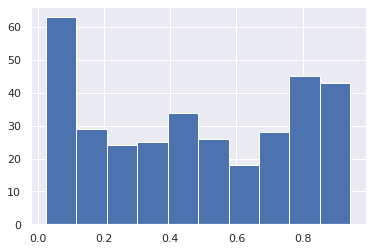

In [57]:
eval_df_all['pred'].hist()

In [58]:
show_eval_results(eval_df_all)

      s2015     s2016     s2017     s2018    s2019   total
0  0.457579  0.493968  0.434052  0.467983  0.35542  0.4418


In [59]:
for th in [0.01,0.02,0.03,0.04,0.05,0.06,0.07,0.08,0.09,0.1]:
    tmp = eval_df_all.copy()
    tmp['pred'] = np.clip(tmp['pred'],th,1-th)
    print('th:'+str(th))
    show_eval_results(tmp)
    print()

th:0.01
      s2015     s2016     s2017     s2018    s2019   total
0  0.457579  0.493968  0.434052  0.467983  0.35542  0.4418

th:0.02
      s2015     s2016     s2017     s2018    s2019   total
0  0.457579  0.493968  0.434052  0.467983  0.35542  0.4418

th:0.03
      s2015     s2016     s2017     s2018     s2019     total
0  0.457579  0.493968  0.434052  0.468062  0.355432  0.441819

th:0.04
      s2015     s2016     s2017     s2018     s2019     total
0  0.457579  0.493968  0.434052  0.468217  0.355943  0.441952

th:0.05
      s2015     s2016     s2017     s2018     s2019    total
0  0.457579  0.493968  0.434061  0.468483  0.356859  0.44219

th:0.06
      s2015     s2016     s2017     s2018     s2019     total
0  0.457579  0.493968  0.434425  0.466508  0.357865  0.442069

th:0.07
      s2015     s2016     s2017     s2018     s2019     total
0  0.457879  0.493968  0.435312  0.465057  0.359331  0.442309

th:0.08
     s2015     s2016     s2017     s2018     s2019     total
0  0.45861  0.

## make_sub

In [28]:
th = 0.04

In [29]:
submission = test[['ID', 'Pred']].copy()
pred = np.zeros(test.shape[0])

model = LogisticRegression()
model.fit(train[select_features],train[target])
pred = model.predict_proba(test[select_features])[:,1]
pred = np.clip(pred,th,1-th)
test['Pred'] = pred
submission['Pred'] = pred

In [30]:
tmp = test.merge(tourny_data[['Season','T1_TeamID', 'T2_TeamID','win']], on=['Season','T1_TeamID', 'T2_TeamID'],how='inner')
log_loss(tmp[target], tmp['Pred'])

0.36778122133408375

<AxesSubplot:>

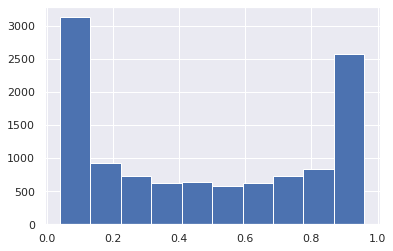

In [31]:
submission['Pred'].hist()

In [32]:
submission.to_csv(OUTPUT_DIR + '/submission.csv', index=False)

In [33]:
submission

,ID,Pred
0,2015_1107_1112,0.040000
1,2015_1107_1116,0.077641
2,2015_1107_1124,0.072298
3,2015_1107_1125,0.462215
4,2015_1107_1129,0.161298
...,...,...
11385,2019_1449_1459,0.256146
11386,2019_1449_1463,0.859085
11387,2019_1458_1459,0.350802
11388,2019_1458_1463,0.905363
